<a href="https://colab.research.google.com/github/G-Conard/ds595-final-project/blob/main/LSTM_nee_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20
185/185 [==============================] - 71s 341ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/20
185/185 [==============================] - 52s 283ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
185/185 [==============================] - 52s 282ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 4/20
185/185 [==============================] - 53s 288ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/20
185/185 [==============================] - 53s 286ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/20
185/185 [==============================] - 54s 291ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/20
185/185 [==============================] - 52s 281ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/20
185/185 [==============================] - 5

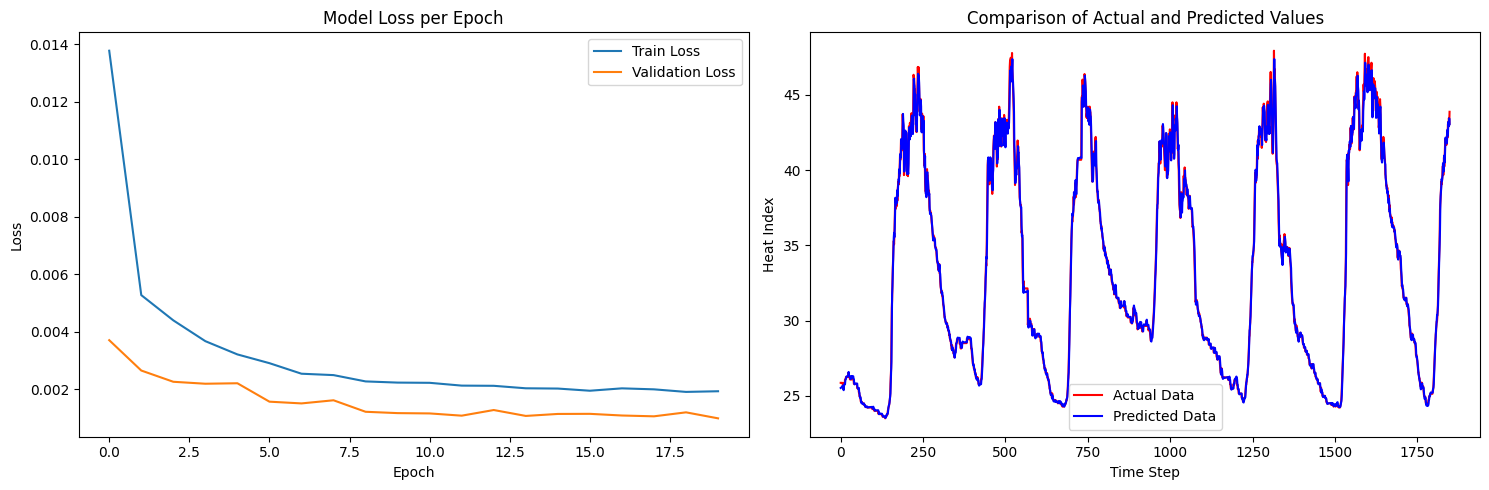

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load and prepare data
data = pd.read_csv('/content/weather_stations_data NEW.csv')
data = data.dropna()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data[['heat_index']].values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
sc = scaler.fit_transform(data)

# Define timestep for the model
timestep = 288
X, Y = [], []
for i in range(len(sc) - timestep):
    X.append(sc[i:(i + timestep)])
    Y.append(sc[i + timestep])
X, Y = np.array(X), np.array(Y)
X = X[:, :, None]  # Reshape for LSTM [samples, time steps, features]

# Split the data into training and test sets
split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_test, Y_test = X[split_idx:], Y[split_idx:]

# Build the model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(timestep, 1), return_sequences=True),
    Dropout(0.1),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mse = model.evaluate(X_test, Y_test, verbose=1)

# Print the results
print("Test Loss:", test_loss)
print("Test MSE:", test_mse)

# Plot the training and validation loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Predict using the model
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Inverse transform to original scale
Y_test_rescaled = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Also inverse transform actual data

# Plotting the results of predictions
plt.subplot(1, 2, 2)
plt.plot(Y_test_rescaled, label='Actual Data', color='red')
plt.plot(predicted, label='Predicted Data', color='blue')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Heat Index')
plt.legend()

plt.tight_layout()
plt.show()
